# Automatic Speech Recognition, Translation & Automatic Subtitles Alignment

Have you ever thought how cool it would be to speak in your own langauge to a person from another country. Well, it might be that they do not understand what you are saying at all... <br>
OpenAI's Whisper comes to help us, by providing us with easy means to generate automatic translation. <br><br>
In this post, I will show you how one can use OpenAI Whisper automatic speech recognition model to generate accurate translations. Then, I will merge this functionality with Python's MoviePy package to generate automatic, aligned subtitles for any video clip.

## Required dependencies

First things first, we will need FFMPEG and ImageMagick. The easiest way to install FFMPEG, without too much trouble from dowloading the correct binary and setting up the PATH environment variables, is to use Chocolatey package installer for Windows. 

### Chocolatey

Chocolatey is a Windows package manager, created to compete with the ease of installing and managing packages on Linux systems.<br>
You can use the following command in PowerShell to install Chocolatey. You will need to launch an administrator-level PowerShell console:

```Set-ExecutionPolicy Bypass -Scope Process -Force; [System.Net.ServicePointManager]::SecurityProtocol = [System.Net.ServicePointManager]::SecurityProtocol -bor 3072; iex ((New-Object System.Net.WebClient).DownloadString('https://community.chocolatey.org/install.ps1'))```

You can check other details on the official Chocolatey page: https://chocolatey.org/install

### FFMPEG

FFmpeg is a free and open-source software consisting of a suite of libraries and programs for handling video, audio, and other multimedia files and streams. 

Once you have Chocolatey, you simply install FFMPEG from the command line: <br>
```choco install ffmpeg``` 

### ImageMagick

ImageMagick is a free, open-source software suite, used for editing and manipulating digital images. It can be used to create, edit, compose, or convert bitmap images. We will need it to use MoviePy package functionality.

You can download it from the following page: https://imagemagick.org/script/download.php

### Python dependencies

Once everything is installed, we can start using the utilities by importing required packages and embedding the transcribing, translating, clip editing functionalities in the Python source code.

In [1]:
# this code cell is only to avoid DLL error in Jupyter notebook
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [34]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import whisper

from IPython.display import Video
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from scipy import signal
from scipy.fft import fft

## Exploration of the audio sample

In [3]:
AUDIO = "data/sample_whisper_model.mp4"

In this section we will shortly inspect how the audio sample looks like, what kind of low-level features can be extracted, what are we going to work on. FIrst, we need to load the audio sample using Whisper's load_audio method.

In [4]:
sample = whisper.load_audio(AUDIO)

In [5]:
print(type(sample))
print(sample.shape)

<class 'numpy.ndarray'>
(407893,)


As we can see, we will be dealing with Numpy array that holds the signal data of the processed audio sample. We can plot a waveform easily using Matplotlib. 

In [6]:
def plot_waveform(signal: np.array, sr: int, title: str, save_to: str) -> None:
    duration = len(signal) / sr
    total_time = np.arange(0, duration, 1/sr)

    sns.set_style(style="whitegrid")
    plt.plot(total_time, signal, color='b')
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.savefig(save_to)

    return None


Since we know that the video takes around 7 seconds, we can estimate that the sampling rate in this case is 16000 Hz. We will assigned it to a constant that will be re-used for the exploratory part.

In [7]:
SR = 16_000

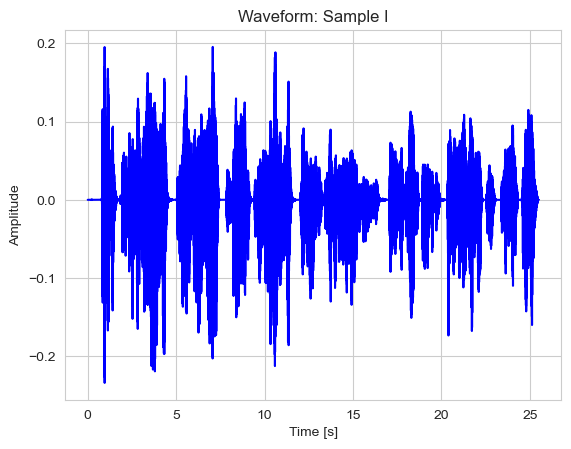

In [8]:
plot_waveform(signal=sample, sr=SR, title="Waveform: Sample I", save_to="assets/images/2_1_waveform_sample_I.png")

We can see the visual representation of the audio we are processing - the plot displays the audio's amplitude in time.

We can also inspect the mel-spectrogram with intensities expressed in the perceptual scale (decibeles), which can be done with Librosa library. Because we are analyzing human speech, this melodic (mel) scale suits the frequencies of interest just fine.

In [19]:
def get_mel_spectrogram(audio_signal, sampling_rate, title: str, save_to: str):
    power_spectrum = librosa.feature.melspectrogram(y=audio_signal, sr=sampling_rate)
    ps_db= librosa.power_to_db(power_spectrum, ref=np.max)
    librosa.display.specshow(ps_db, x_axis='s', y_axis="log")
    plt.title(title)
    plt.savefig(save_to)

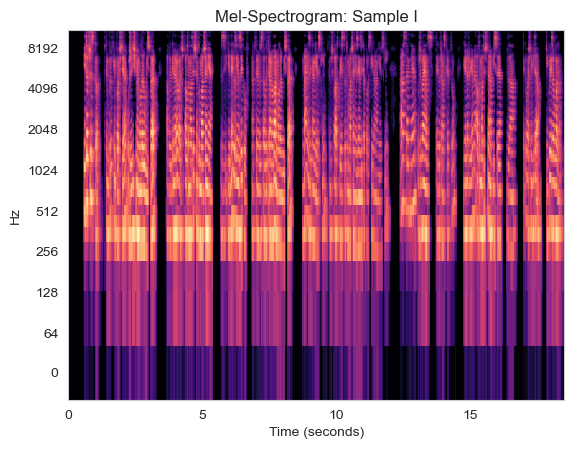

In [20]:
get_mel_spectrogram(audio_signal=sample, sampling_rate=SR, title="Mel-Spectrogram: Sample I", save_to="assets/images/2_3_mel_spectrogram1_sample_I.png")

Now, having an initial overview of the sound we will be analyzing with Whisper, let's define a class for the translator and see what features can be extracted with Whisper.

In [21]:
class Translator:
    """
    Class providing functionality for transcribing, translating and detecting language.
    Parameters:
        - model_name: str, path to the pre-trained model or model name (tiny, small, medium, large)
        - device: str (cuda | cpu)
        - number_mels: int, the number of mel audio features used for the input
    """
    def __init__(self, model_name, device=None, number_mels: int = 80) -> None:
        self.model_name = model_name

        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = "cpu"

        self.model = whisper.load_model(self.model_name, device=self.device)
        self.number_mels = number_mels

    def get_sample(self, audio) -> np.array:
        """
        Pre-processing functionality for the audio sample.
        """
        return whisper.pad_or_trim(audio)
    
    def get_sample_mel_spectrogram(self, audio):
        """
        Retrieval of the mel spectrogram for the provided audio sample.
        Parameters: 
            - audio: whisper.load_audio pre-processed audio sample.
        Returns: 
            A spectrogram representation of the audio.
        """
        sample = self.get_sample(audio=audio)
        return whisper.log_mel_spectrogram(sample, n_mels=self.number_mels).to(self.device)
    
    def detect_language(self, audio):
        """
        Method for language recognition based on the retrieved spectrogram.
        Parameters:
            - audio: the whisper.load_audio sample
        Returns:
            - an array of probabilities corresponding to each available language.
        """
        sample = self.get_sample(audio=audio)
        spectrogram = whisper.log_mel_spectrogram(audio=sample, n_mels=self.number_mels).to(self.device)
        return self.model.detect_language(spectrogram)
    
    def __process_audio(self, audio, task_type: str = "transcribe"):
        """
        A private method for detecting the language to maximize performance, and creating the audio transcription.
        Parameters:
            - audio: whisper.load_audio pre-processed audio sample
            - task_type: str, transcribe or translate
        Returns:
            The audio sample's transcription.
        """
        _, language_probabilities = self.detect_language(audio=audio)
        most_probable_language = max(language_probabilities, key=language_probabilities.get)
        return self.model.transcribe(audio=audio, language=most_probable_language, task=task_type)
    
    def transcribe_audio(self, audio):
        return self.__process_audio(audio=audio, task_type="transcribe")
    
    def translate_to_english(self, audio):
        return self.__process_audio(audio=audio, task_type="translate")


## Exploring Whisper model's functionality

First, let's instantiate the Translator class with a small model, operating on the CPU and with 80 mel features.

In [22]:
translator = Translator(model_name="small", device="cpu", number_mels=80)

In [23]:
audio_sample = whisper.load_audio(AUDIO)

Similarly, as before, we can get a sample's Mel-spectrogram, however, this time it is fit to the expected inputs of the Whisper model. Nevertheless, it is interesting to see what the model is operating on to extract features such as the detected language. 

In [24]:
def get_whisper_mel_spectrogram(audio_sample: np.array, title: str, save_to: str):
    plt.figure(figsize=(10, 15))
    plt.imshow(translator.get_sample_mel_spectrogram(audio_sample))
    plt.title(title)
    plt.savefig(save_to)

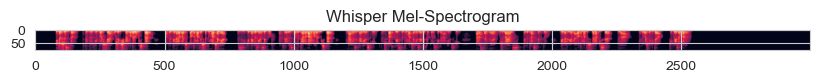

In [25]:
get_whisper_mel_spectrogram(audio_sample=audio_sample, 
                            title="Whisper Mel-Spectrogram", 
                            save_to="assets/images/2_4_mel_spectrogram2_sample_I.png")

Now, having the entire Translator ready, we can try to translate any source in an arbitrary language to English. Let's have a look at the detected language first.

## Assessing the functionality

In [26]:
_, probs = translator.detect_language(audio=audio_sample)

reverted_dictionary = {k: round(v, 4) for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
# let's have a look at 3 most probable languages

counter = 0
for k, v in reverted_dictionary.items():
    if counter > 2:
        break
    else:
        print(f"Language: {k}   Probability: {v}")
        counter += 1


Language: pl   Probability: 0.998
Language: en   Probability: 0.0008
Language: ru   Probability: 0.0002


Now, we will get the transcription of the audio. Let's inspect what kind of information we can find in the returned object.

In [27]:
transcription = translator.transcribe_audio(audio=audio_sample)
print(transcription.keys())

dict_keys(['text', 'segments', 'language'])


The 'text' key contains just a single string: the obtained full transcription. 
'language' is simply the detected language. 'segments' is the most interesting key, because it stores the transcription divided into time segments. It is very handy, because it makes the automatic alignment of subtitles much easier. 

In [28]:
for element in transcription["segments"]:
    for k, v in element.items():
        print(f"Key: {k}    Value: {v}")

Key: id    Value: 0
Key: seek    Value: 0
Key: start    Value: 0.0
Key: end    Value: 13.0
Key: text    Value:  I to wszystko. W tym krótkim poście użyliśmy modelu whisper, aby generować automatyczne tłumaczenie jednego z języków, na którym został wytranowany model whisper, na język angielski.
Key: tokens    Value: [50364, 286, 281, 22607, 13, 343, 8107, 42366, 83, 25112, 714, 9815, 34097, 38452, 2316, 84, 26018, 11, 24457, 1337, 11445, 28034, 17466, 716, 256, 49166, 326, 16778, 5232, 11858, 710, 49055, 23849, 11, 1667, 30120, 23154, 1221, 261, 4328, 4257, 23341, 2316, 26018, 11, 1667, 49055, 74, 2562, 1187, 18020, 13, 51014]
Key: temperature    Value: 0.0
Key: avg_logprob    Value: -0.13633512293250816
Key: compression_ratio    Value: 1.5238095238095237
Key: no_speech_prob    Value: 0.019939523190259933
Key: id    Value: 1
Key: seek    Value: 0
Key: start    Value: 13.0
Key: end    Value: 25.0
Key: text    Value:  W tym przypadku jest to tłumaczenie z języka polskiego na angielski. A 

As we can see, we get the start, end indices, the text for each segment, the tokenized text array, the temperature model hyperparemeter, and other interesting features. The average log-probability, the compression ratio, and the probability of silent part.        

The compression ratio is a measure on the repeated sequences. In a nutshell, a text with many repeated sequences can be compressed down much more than a text with sequences occurring only once. 
It allows to prevent the model repeating itself when it generates the preditions for the sequences.

## Let's generate the clip!

Finally, it is time to use the model in practice and embed it in MoviePy functionality to create a clip with English subtitles for our output translation.

In [40]:
def create_video(transcription_data: dict, clip_path: str, output_path: str):
    # Load the video clip
    video_clip = VideoFileClip(clip_path)

    # Create TextClip for each subtitle
    subtitle_clips = []
    for segment in transcription_data["segments"]:
        start_time = int(segment["start"])
        end_time = int(segment["end"])
        duration = end_time - start_time
        caption_clip = TextClip(segment["text"], fontsize=16, color="white", bg_color="transparent", stroke_color="black", stroke_width=0.2)
        caption_clip = caption_clip.set_pos(("center", "bottom"))
        caption_clip = caption_clip.set_duration(duration)
        caption_clip = caption_clip.set_start(start_time)
        subtitle_clips.append(caption_clip)

    # Combine all caption clips into a single CompositeVideoClip
    subtitles = CompositeVideoClip(subtitle_clips)

    # Overlay subtitles at the bottom of the video
    final_clip = CompositeVideoClip([video_clip, subtitles.set_pos(("center", "bottom"))])
    # final_clip = CompositeVideoClip([video_clip])

    # Write the final video
    final_clip.write_videofile(output_path, codec="libx264", audio_codec="aac", fps=24, remove_temp=True)

    return 0


audio = whisper.load_audio(AUDIO)
transcription = translator.translate_to_english(audio=audio)
create_video(transcription_data=transcription, clip_path="data/sample_whisper_model.mp4", 
             output_path="assets/videos/output_whisper_model_clip.mp4")


Moviepy - Building video assets/videos/output_whisper_model_clip.mp4.
MoviePy - Writing audio in output_whisper_model_clipTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video assets/videos/output_whisper_model_clip.mp4



Moviepy - Done !
Moviepy - video ready assets/videos/output_whisper_model_clip.mp4


0

<video width="800" height="500" controls>
  <source src="assets/videos/output_whisper_model_clip.mp4" type="video/mp4">
  <source src="assets/videos/output_whisper_model_clip.ogg" type="video/ogg">
Your browser does not support the video tag.
</video>
